# **RNN Introduction**


## Importing required libraries


In [35]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
import math


## Loading and preprocessing the data
### Dataset 4-Deep learning/5-Time Series Forecasting (RNN)/LAB/ٌDatasets/traffic.csv

In [3]:
df = pd.read_csv('/content/traffic.csv')
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [6]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB


In [7]:
df.isna().sum()

,0
DateTime,0
Junction,0
Vehicles,0
ID,0


In [8]:
df.duplicated().sum()

0

## Visualization

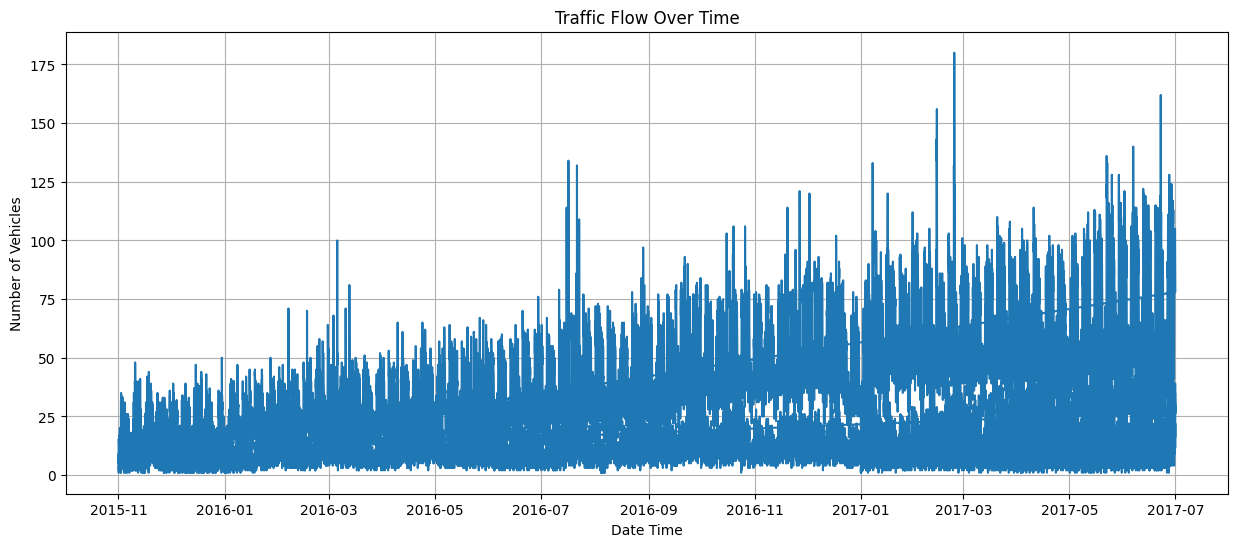

In [9]:
plt.figure(figsize=(15,6))
plt.plot(df['DateTime'], df['Vehicles'])
plt.xlabel('Date Time')
plt.ylabel('Number of Vehicles')
plt.title('Traffic Flow Over Time')
plt.grid(True)
plt.show()

## Split the data into train and test

In [10]:
# Split into training and testing sets
train_size = int(len(df) * 0.8)  # 80% for training
train_data, test_data = df[:train_size], df[train_size:]

In [20]:
# Define the sequence length (number of past time steps)
n_past = 60
# Prepare sequences for RNN
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data['Vehicles'].iloc[i - n_past:i].values)
    y_train.append(train_data['Vehicles'].iloc[i])
X_train, y_train = np.array(X_train), np.array(y_train)
# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data['Vehicles'].iloc[i - n_past:i].values)
    y_test.append(test_data['Vehicles'].iloc[i])
X_test, y_test = np.array(X_test), np.array(y_test)

In [21]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(38436, 60)
(38436,)


Testing set size:-
(9564, 60)
(9564,)


(None, None)

In [22]:
# Reshape input data for RNN([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Modeling


In [25]:
# Initialize a sequential model
model = Sequential()

# First RNN layer with 50 units, input shape, and return sequences
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Second RNN layer with 50 units and return sequences
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third RNN layer with 50 units
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 60, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 60, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,751 (49.81 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [31]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.keras', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our RNN model
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=10,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 68s 56ms/step - loss: 76.3337 - val_loss: 29.4959
Epoch 2/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 76s 52ms/step - loss: 61.3766 - val_loss: 31.4891
Epoch 3/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 83s 53ms/step - loss: 58.1412 - val_loss: 30.5263
Epoch 4/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - loss: 56.3723 - val_loss: 28.2392
Epoch 5/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - loss: 53.6054 - val_loss: 31.5432
Epoch 6/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - loss: 51.9485 - val_loss: 32.8471
Epoch 7/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 82s 53ms/step - loss: 48.7764 - val_loss: 29.0843
Epoch 8/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 81s 52ms/step - loss: 46.8784 - val_loss: 37.6445
Epoch 9/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - loss: 45.0778 - val_loss: 30.9074
Epoch 10/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - loss: 44.8480 - val_loss: 30.6405


In [32]:
# Let's do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

1202/1202 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


In [36]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict)))

5.226005998809918
5.314055750602983


## Visualization of results


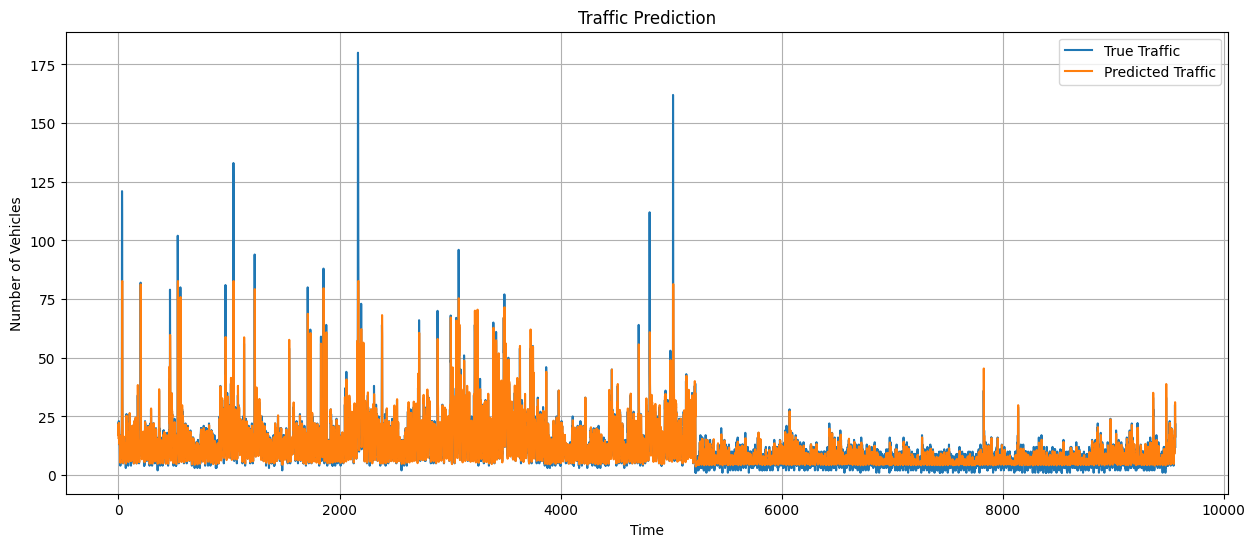

In [37]:
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='True Traffic')
plt.plot(test_predict, label='Predicted Traffic')
plt.xlabel('Time')
plt.ylabel('Number of Vehicles')
plt.title('Traffic Prediction')
plt.legend()
plt.grid(True)
plt.show()
